In [1]:
import Gym
import Random
import Flux
import Flux: Chain, Dense, relu, tanh, glorot_uniform
import ProgressBars: ProgressBar
using Plots
using Statistics

const F = Float32

Float32

# Advantage Actor-Critic (A2C) Method

In [2]:
mutable struct AgentHistory
    nS::Int
    nA::Int
    γ::F
    states::Array{F}
    actions::Array{Int}
    rewards::Array{F}
end
AgentHistory(nS, nA, γ) = AgentHistory(nS, nA, γ, zeros(0),zeros(Int, 0),zeros(0))

AgentHistory

In [3]:
function compute_discounted_returns(rewards; γ=0.95)
    N = length(rewards)
    discount_exps = γ.^(1:N)
    rev_discounted_rewards = reverse(discount_exps .* rewards)
    cum_discounted_rewards = reverse(cumsum(rev_discounted_rewards, dims=1))
    R = cum_discounted_rewards ./ discount_exps
    return (R .- mean(R)) ./ (std(R) + F(1e-10)) #speeds up training a lot
#     return R
end



compute_discounted_returns (generic function with 1 method)

In [4]:
function sample_action(probs)
    probs = Array(probs)
    cprobs = cumsum(probs, dims=1)
    sampled = cprobs .> rand() 
    sampled_action = mapslices(argmax, sampled, dims=1)[1]
    return sampled_action
end

sample_action(Vector(1:10)/55)

6

In [22]:
function init_actor_weights(hidden_units; x_dim=4, y_dim=2)
    layers = []
    x = x_dim
    for y in [hidden_units...]
        push!(layers, Dense(x, y, relu; bias=true, init=glorot_uniform))
        x = y
    end
    push!(layers, Dense(x, y_dim; bias=true, init=glorot_uniform)) # Prob actions
    return Chain(layers...)
end

function init_critic_weights(hidden_units; x_dim=4)
    layers = []
    x = x_dim
    for y in [hidden_units...]
        push!(layers, Dense(x, y, relu; bias=true, init=glorot_uniform))
        x = y
    end
    push!(layers, Dense(x, 1; bias=true, init=glorot_uniform)) # Value function
    return Chain(layers...)
end


w_ = init_ac_weights([1,3,4])

5-element Vector{Any}:
 Dense(4, 1, relu)   # 5 parameters
 Dense(1, 3, relu)   # 6 parameters
 Dense(3, 4, relu)   # 16 parameters
 Dense(4, 2)         # 10 parameters
 Dense(4, 1)         # 5 parameters

In [6]:
function predict(layers, x)
    x = float.(x)
    shared_output = x
    for layer in layers
       shared_output = layer(shared_output) 
    end
    prob_act_pre_scale = layers[end-1](shared_output)
    value = layers[end](shared_output)
    return prob_act_pre_scale, value
end

predict (generic function with 1 method)

In [7]:
L2fn(x) = sum(x .* x)

function actor_loss(actor_ws, critic_ws, agent_history)
    nS, nA = agent_history.nS, agent_history.nA
    M = length(agent_history.states) ÷ nS
    states = reshape(agent_history.states, nS, M)
    R = compute_discounted_returns(agent_history.rewards, γ=agent_history.γ)
    
    p, V = predict(actor_ws, critic_ws, states)
    V = vec(V)
    A = R .- V   # advantage  
    inds = agent_history.actions + nA * (0:M-1)
    lsp = Flux.logsoftmax(p, dims=1)[inds] # lsp is a vector
    return -sum(lsp .* A) + L2fn(A)
end

critic_loss (generic function with 1 method)

In [8]:
import ReinforcementLearning
import StableRNGs

function main_a2c(env_fn;
    hidden = [40, 20, 10], # width inner layers
    lr = 1e-3,
    γ = 0.99, #discount rate
    episodes = 3000,
    render = true,
    seed = 7,
    infotime = 50
)
    
    seed > 0 && Random.seed!(seed)
    env = env_fn(; rng = StableRNGs.StableRNG(hash(seed)))
    nS, nA = 4, 2
    w_actor = init_actor_weights(hidden, x_dim=nS, y_dim=nA)
    println(w_actor)
    w_critic = init_critic_weights(hidden, x_dim=nS)
    opt_a = Flux.ADAM(lr)
    opt_c = Flux.ADAM(lr)
    avgreward = 0
    avgrewards = []
    for episode=1:episodes
        ReinforcementLearning.RLBase.reset!(env)
        episode_rewards = 0
        history = AgentHistory(nS, nA, γ)
        state = env.state
        for t=1:10000
            p, V = predict(w_actor, w_critic, state)
            p = Flux.softmax(p, dims=1)
            action = sample_action(p)
            reward = ReinforcementLearning.RLBase.reward(env)
            append!(history.states, float(state))
            push!(history.actions, action)
            push!(history.rewards, reward)
            env(action)
            state = env.state
            episode_rewards += reward
            env.done && break
        end
        avgreward = 0.1 * episode_rewards + avgreward * 0.9
        push!(avgrewards, avgreward)
        if episode % infotime == 0
            println("(episode:$episode, avgreward:$avgreward)")
        end
        ps_prob = Flux.params(w_actor)
        ps_val = Flux.params(w_critic)
        Flux.train!(actor_loss, ps_prob, [(w_actor, w_critic, history,)], opt_a)
        Flux.train!(critic_loss, ps_val, [(w_actor, w_critic, history,)], opt_c)
    end

    return w_actor, w_critic, avgrewards
end

main_a2c (generic function with 1 method)

In [23]:
a2c_w_actor, a2c_w_critic, a2c_avgrewards = main_a2c(ReinforcementLearning.CartPoleEnv)

Chain(Dense(4, 40, relu), Dense(40, 20, relu), Dense(20, 10, relu), Dense(10, 2))
(episode:50, avgreward:19.75021049039075)
(episode:100, avgreward:34.329140895387376)
(episode:150, avgreward:49.762782308651474)
(episode:200, avgreward:123.35026478171267)
(episode:250, avgreward:138.8860520700159)
(episode:300, avgreward:166.81882207634766)
(episode:350, avgreward:198.17592046311185)
(episode:400, avgreward:192.81336155773087)
(episode:450, avgreward:200.5438702899582)
(episode:500, avgreward:199.45558474825341)
(episode:550, avgreward:200.8236446066923)
(episode:600, avgreward:137.96348955591694)
(episode:650, avgreward:200.51689965531625)
(episode:700, avgreward:196.37161577842005)
(episode:750, avgreward:200.9761463481489)
(episode:800, avgreward:200.99987706364047)
(episode:850, avgreward:200.99999936641362)
(episode:900, avgreward:200.99999999673463)
(episode:950, avgreward:183.7511153377654)
(episode:1000, avgreward:200.8209526013374)
(episode:1050, avgreward:188.66869512235584)


(Chain(Dense(4, 40, relu), Dense(40, 20, relu), Dense(20, 10, relu), Dense(10, 2)), Chain(Dense(4, 40, relu), Dense(40, 20, relu), Dense(20, 10, relu), Dense(10, 1)), Any[3.1, 3.89, 6.501, 8.8509, 10.565809999999999, 12.009229, 13.3083061, 13.77747549, 13.999727941, 14.4997551469  …  200.64988076786773, 200.68489269108096, 200.71640342197287, 200.7447630797756, 200.77028677179803, 200.7932580946182, 200.8139322851564, 200.83253905664077, 195.04928515097671, 195.64435663587903])

https://github.com/MZayed47/A3C_Agent/blob/main/A3C-Cartpole/cartpole.py

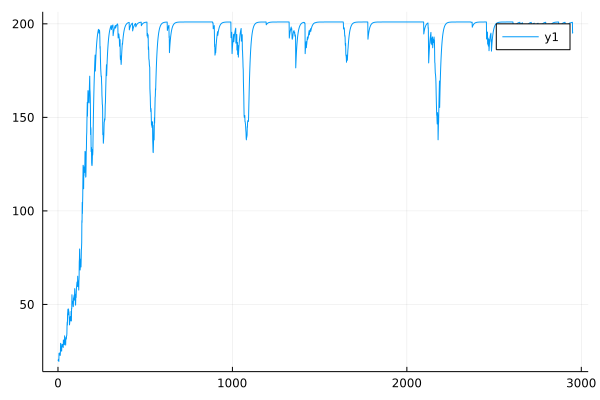

In [10]:
plot(a2c_avgrewards[50:end])



## Asynchronous Advantage Actor Critic (A3C)

In [18]:
import ReinforcementLearning
import StableRNGs
N_THREADS = Threads.nthreads()

function main_a3c(env_fn;
    hidden = [40, 20, 10], # width inner layers
    lr = 1e-3,
    γ = 0.99, #discount rate,
    num_agents = N_THREADS,
    time_step_update = 10,
    episodes = 3000,
    render = true,
    seed = 5,
    infotime = 50
)
    seed > 0 && Random.seed!(seed)
    env = env_fn()
    nS, nA = length(ReinforcementLearning.state(env)), length(ReinforcementLearning.action_space(env))
    weights_lock = Threads.SpinLock()
    shared_actor_weights = init_actor_weights(hidden, x_dim=nS, y_dim=nA)
    shared_critic_weights = init_critic_weights(hidden, x_dim=nS)
    actor_weights_threads = [init_actor_weights(hidden, x_dim=nS, y_dim=nA) for _ in 1:num_agents]
    critic_weights_threads = [init_critic_weights(hidden, x_dim=nS) for _ in 1:num_agents]
    opt = Flux.ADAM()
    avgrewards = [[0.0] for _ in 1:episodes]
    shared_avgrewards = [0.0 for _ in 1:episodes]
    
    Threads.@threads for agent_id in 1:num_agents
        for episode=1:episodes
            params_shared_actor = Flux.params(shared_actor_weights)
            params_shared_critic = Flux.params(shared_critic_weights)
            actor_weights_threads[agent_id] = shared_actor_weights
            critic_weights_threads[agent_id] = shared_critic_weights
            env_thread = env_fn()
            ReinforcementLearning.RLBase.reset!(env_thread)
            state = env_thread.state
            
            episode_rewards = 0
            history = AgentHistory(nS, nA, γ)
            for t=1:10000
                p, V = predict(actor_weights_threads[agent_id], critic_weights_threads[agent_id], state)
                p = Flux.softmax(p, dims=1)
                action = sample_action(p)
                append!(history.states, float(state))
                reward = ReinforcementLearning.RLBase.reward(env_thread)
                push!(history.actions, action)
                push!(history.rewards, reward)
                env_thread(action)
                state = float(env_thread.state)
                episode_rewards += reward
                env_thread.done && break
            end
            avgreward = 0.1 * episode_rewards + avgrewards[agent_id][end] * 0.9
            push!(avgrewards[agent_id], avgreward)
            grads_actor = Flux.gradient(() -> actor_loss(actor_weights_threads[agent_id], critic_weights_threads[agent_id], history), Flux.params(actor_weights_threads[agent_id]))
            grads_critic = Flux.gradient(() -> critic_loss(actor_weights_threads[agent_id], critic_weights_threads[agent_id], history), Flux.params(critic_weights_threads[agent_id]))
            lock(weights_lock) do
                Flux.update!(opt, params_shared_actor, grads_actor) 
                Flux.update!(opt, params_shared_critic, grads_critic) 
                shared_avgrewards[episode] += avgreward
            end
        end
    end
    shared_avgrewards /= num_agents
    
    return shared_actor_weights, shared_critic_weights, shared_avgrewards
end

main_a3c (generic function with 1 method)

In [19]:
a3c_shared_actor_weights, a3c_shared_critic_weights, a3c_avgrewards = main_a3c(ReinforcementLearning.CartPoleEnv)

(Chain(Dense(4, 40, relu), Dense(40, 20, relu), Dense(20, 10, relu), Dense(10, 2)), Chain(Dense(4, 40, relu), Dense(40, 20, relu), Dense(20, 10, relu), Dense(10, 1)), [1.6500000000000001, 3.3600000000000003, 4.7490000000000006, 5.9741, 6.95169, 8.231521, 10.283368900000001, 11.255032010000003, 13.054528809000002, 13.549075928100002  …  200.93872975226236, 200.94485677703614, 200.95037109933253, 200.95533398939926, 200.95980059045934, 200.96382053141343, 200.96743847827207, 200.97069463044488, 200.97362516740037, 200.97626265066035])

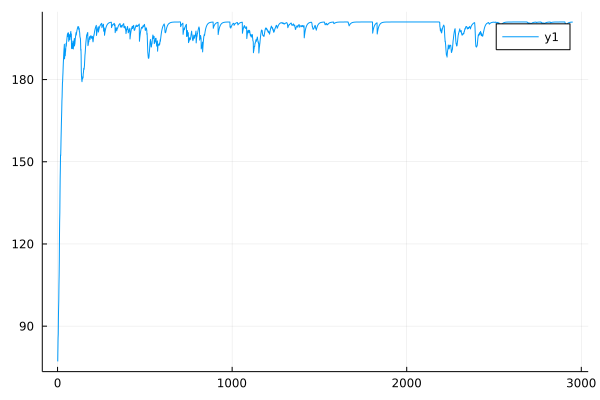

In [20]:
plot(a3c_avgrewards[50:end])

In [21]:
a3c_avgrewards

3000-element Vector{Float64}:
   1.6500000000000001
   3.3600000000000003
   4.7490000000000006
   5.9741
   6.95169
   8.231521
  10.283368900000001
  11.255032010000003
  13.054528809000002
  13.549075928100002
  15.86916833529
  15.482251501761
  15.984026351584902
   ⋮
 200.9243577188424
 200.9319219469582
 200.93872975226236
 200.94485677703614
 200.95037109933253
 200.95533398939926
 200.95980059045934
 200.96382053141343
 200.96743847827207
 200.97069463044488
 200.97362516740037
 200.97626265066035

Potential ideas

* use https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/blob/f4cf555f50e0333254ab099f5a643a587ec532d7/src/ReinforcementLearningExperiments/deps/experiments/experiments/Policy%20Gradient/JuliaRL_A2CGAE_CartPole.jl
    * but note that this link only does A2C on multiple environments for different seeds, not for training different agents --> this is the key difference --> meaning that we're combining data from multiple threads
    * First get this to work on single seed, multiple agents, CartPoleEnv and then move on to different environments and or multiple seeds as well


In [17]:
import Zygote
Zygote.Grads()

LoadError: MethodError: no method matching Zygote.Grads()
[0mClosest candidates are:
[0m  Zygote.Grads([91m::IdDict{Any, Any}[39m, [91m::Zygote.Params[39m) at C:\Users\skarn\.julia\packages\Zygote\ytjqm\src\compiler\interface.jl:249
[0m  Zygote.Grads([91m::Any[39m, [91m::Any[39m) at C:\Users\skarn\.julia\packages\Zygote\ytjqm\src\compiler\interface.jl:249

In [18]:
mod(9,3)

0

In [19]:
import Knet

In [20]:
ReinforcementLearning.CartPoleEnv()

# CartPoleEnv

## Traits

| Trait Type        |                                            Value |
|:----------------- | ------------------------------------------------:|
| NumAgentStyle     |          ReinforcementLearningBase.SingleAgent() |
| DynamicStyle      |           ReinforcementLearningBase.Sequential() |
| InformationStyle  | ReinforcementLearningBase.ImperfectInformation() |
| ChanceStyle       |           ReinforcementLearningBase.Stochastic() |
| RewardStyle       |           ReinforcementLearningBase.StepReward() |
| UtilityStyle      |           ReinforcementLearningBase.GeneralSum() |
| ActionStyle       |     ReinforcementLearningBase.MinimalActionSet() |
| StateStyle        |     ReinforcementLearningBase.Observation{Any}() |
| DefaultStateStyle |     ReinforcementLearningBase.Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`ReinforcementLearningBase.Space{Vector{IntervalSets.ClosedInterval{Float64}}}(IntervalSets.ClosedInterval{Float64}[-4.8..4.8, -Inf..Inf, -0.41887902047863906..0.41887902047863906, -Inf..Inf])`

## Action Space

`Base.OneTo(2)`

## Current State

```
[0.04267686815738801, 0.005131182574376211, 0.018164667732251297, -0.0005420664545555259]
```
